In [ ]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm

In [33]:
lith = np.zeros((400,200))
lith[:150,:] = 1
lith[150:250,:] = 2

In [34]:
layer_1 = ss.norm(250, 35)
layer_2 = ss.norm(150, 25)

layers = [layer_1, layer_2]

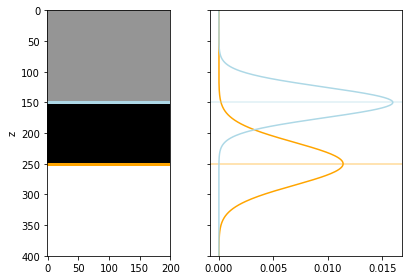

In [35]:
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].imshow(lith, origin="lower", cmap="Greys")

ax[0].set_ylabel("z");


ax[0].axhline(250, color="orange", alpha=1, linewidth=3)
ax[0].axhline(150, color="lightblue", alpha=1, linewidth=3)

ax[0].set_ylim(400, 0)

x = np.arange(0,400)
ax[1].plot(layer_1.pdf(x), x, color="orange", alpha=1)
ax[1].axhline(250, color="orange", alpha=0.4)
ax[1].plot(layer_2.pdf(x), x, color="lightblue", alpha=1)
ax[1].axhline(150, color="lightblue", alpha=0.4)
ax[1].set_ylim(400,0)
plt.tight_layout()

# Forward simulation

In [36]:
prior_samples = []
for layer in layers:
    prior_samples.append(layer.rvs(10000))

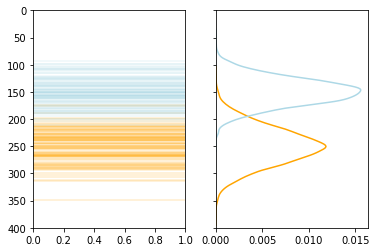

In [40]:
fig, ax = plt.subplots(ncols=2, sharey=True)

colors = ["orange", "lightblue"]
for i, ls in enumerate(prior_samples):
    for s in ls[::100]:
        ax[0].axhline(s, color=colors[i], alpha=0.2)
    sns.distplot(ls, vertical=True, color=colors[i], hist=False, ax=ax[1])
ax[0].set_ylim(400, 0);

# Rejection Sampling (ABC-REJ)

In [106]:
obs_thickness = np.array([160])
obs_norm = ss.norm(obs_thickness.mean(), obs_thickness.std())

Loopy

In [108]:
def abc_rej(n_iter, epsilon, obs_thickness):
    """ABC-REJ algorithm from Sadegh and Vrught (2014)."""
    posterior_l1 = []
    posterior_l2 = []
    obs_thickness = np.array(obs_thickness)

    for i in tqdm.tqdm(range(n_iter)):
        distance = epsilon + 1
        while distance > epsilon:
            l1 = layer_1.rvs()
            l2 = layer_2.rvs()
            thickness = l1 - l2
            distance = np.mean(np.sqrt(np.square(obs_thickness - thickness)))
        posterior_l1.append(l1)
        posterior_l2.append(l2)
        
    return np.stack((posterior_l1, posterior_l2), axis=1)

In [150]:
%%timeit
posterior = abc_rej(1000, 0.1, obs_thickness)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:46<00:00,  9.40it/s]


1min 48s ± 2.89 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


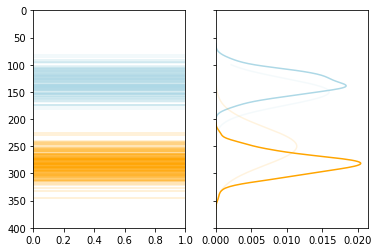

In [154]:
fig, ax = plt.subplots(ncols=2, sharey=True)

if posterior.shape[0] < 200:
    n = posterior.shape[0]
else:
    n=200

for i, ls in enumerate([np.random.choice(posterior[:,0], n, replace=False), 
                        np.random.choice(posterior[:,1], n, replace=False)]):
    for s in ls:
        ax[0].axhline(s, color=colors[i], alpha=0.2)
    sns.distplot(ls, vertical=True, color=colors[i], ax=ax[1], hist=False)

# plot priors for comparison
x = np.arange(100,400)
ax[1].plot(layer_1.pdf(np.arange(100,400)), x, color="orange", alpha=0.13)
ax[1].plot(layer_2.pdf(np.arange(100,400)), x, color="lightblue", alpha=0.13)
ax[0].set_ylim(400, 0);

## adaptive ABC

In [156]:
def abc_adaptive(n_iter, epsilon, obs, prior1, prior2):
    """Starting with a large epsilon, after n_iter successful samples epsilon gets further reduces and the prior distributions replaced by normal distributions
    based on the posterior distributions of the previous sampling round."""
    posterior_p1 = []
    posterior_p2 = []
    obs = np.array(obs)
    epsilons = np.arange(0.1, 10, 0.5)[::-1]
    for epsilon in epsilons:#, 5., 2.5, 1.25, 1, 0.5, 0.25, 0.125]:
        while len(posterior_p1) < n_iter:
            l1 = prior1.rvs()
            l2 = prior2.rvs()
            thickness = l1 - l2
            distance = np.mean(np.sqrt(np.square(obs - thickness)))
            if distance <= epsilon:
                posterior_p1.append(l1)
                posterior_p1.append(l2)
        
        prior1 = ss.norm(loc=np.mean(posterior_l1), scale=np.std(posterior_l1))
        prior2 = ss.norm(loc=np.mean(posterior_l2), scale=np.std(posterior_l2))
        if not epsilon == epsilons[-1]:
            posterior_p1 = []
            posterior_p2 = []
    
    return np.stack((posterior_l1, posterior_l2), axis=1)

In [158]:
#%%timeit
posterior_adaptive = abc_smthn(1000, 10, 150, layer_1, layer_2)

It took this algorithm around 20.7 seconds to approximate the posterior with a 1000 samples using an error margin of $\epsilon = 0.1$. This is more than a five-fold increase in sampling efficiency compared to the ABC-REJ algorithm.

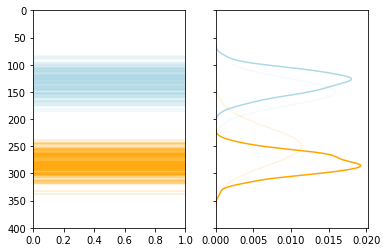

In [159]:
fig, ax = plt.subplots(ncols=2, sharey=True)

if posterior_adaptive.shape[0] < 200:
    n = posterior_adaptive.shape[0]
else:
    n=200

for i, ls in enumerate([np.random.choice(posterior_adaptive[:,0], n, replace=False), 
                        np.random.choice(posterior_adaptive[:,1], n, replace=False)]):
    for s in ls:
        ax[0].axhline(s, color=colors[i], alpha=0.2)
    sns.distplot(ls, vertical=True, color=colors[i], ax=ax[1], hist=False)

# plot priors for comparison
x = np.arange(100,400)
ax[1].plot(layer_1.pdf(np.arange(100,400)), x, color="orange", alpha=0.13)
ax[1].plot(layer_2.pdf(np.arange(100,400)), x, color="lightblue", alpha=0.13)
ax[0].set_ylim(400, 0);

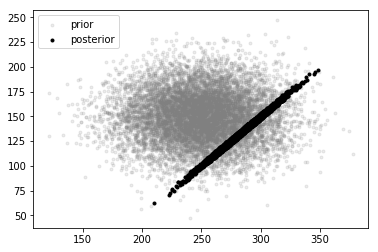

In [177]:
plt.scatter(prior_samples[0], prior_samples[1], marker=".", alpha=0.15, color="grey", label="prior")
plt.scatter(posterior_adaptive[:,0], posterior_adaptive[:,1], marker=".", alpha=1, color="black", label="posterior")
plt.legend();

## Dep

Vectorized

In [11]:
# %%timeit
n_iter = 1000000
epsilon = 10
sample_layer1 = layer_1.rvs(n_iter)
sample_layer2 = layer_2.rvs(n_iter)
thickness = sample_layer1 - sample_layer2
distance = np.mean(np.sqrt(np.square(obs_thickness - np.tile(thickness[:, np.newaxis], 3))), axis=1) 
f = np.argwhere(distance < epsilon)
posterior_l1 = sample_layer1[f]
posterior_l2 = sample_layer2[f]

Vectorized with sampling from observation distribution:

In [94]:
# %%timeit
n_iter = 100000000
epsilon = 0.0001
sample_layer1 = layer_1.rvs(n_iter)
sample_layer2 = layer_2.rvs(n_iter)
thickness = sample_layer1 - sample_layer2
distance = np.sqrt(np.square(obs_norm.rvs(n_iter) - thickness))
f = np.argwhere(distance < epsilon)
posterior_l1 = sample_layer1[f]
posterior_l2 = sample_layer2[f]